In [1]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.stats import skew
import Scope_funcs as sf
import json



imports work
imports work


/Users/bentalmor/Desktop/LUXE/F-Cal-TB-Project/Scope_funcs.py:197: SyntaxWarning: "\T" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\T"? A raw string is also an option.
  file_name = f'TB_FIRE\TB_reco\TB2025_Run_{run_number}.root'


<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

Functions

In [2]:
 # sigmoid
def sigmoid_linear(x, A, t, r):
    return  A / (1.0 + np.exp(-(x - t) * r))

In [3]:
# edges of the pads in the sensor
def pads_to_xy_gridlines(pad_number, pitch=5.53):
    "returns the coordinates of the edges of a pad, pitch is the size of the pad"

    # convert pad number to row and column position
    row = pad_number // 20
    col = pad_number % 20

    # convert the row col to l(tower index) m(x) n(y) coordinates
    l = 1 if col >= 12 else 0
    m = 4 + col - (16 * l)
    n = 3 + row

    # convert (l,m,n) to xy of pad center on the sensor
    x_center = -(86.575 - (5.53 * m) - (90.2 * l))
    y_center = -41.475 + (5.53 * n)
    
    # get the line of the pads edges
    x_left = round(x_center - pitch / 2, 6)  # Left edge
    x_right = round(x_center + pitch / 2, 6)  # Right edge
    y_left = round(y_center - pitch / 2, 6)  # Bottom edge
    y_right = round(y_center + pitch / 2, 6)  # Top edge

    x_lines = [x_left,x_right]
    y_lines = [y_left,y_right]

    return x_lines, y_lines

In [4]:
def multiple_pad_edges_gridlines(pad_list):
    "returns a list of the coordinates of all x and y edges of the pads"

    # change int to list on case given a single pad
    if type(pad_list) == int:
        pad_list = [pad_list]
    
    # get the borders for each pad into a list
    x_lines_list = []
    y_lines_list = []
    for pad in pad_list:
        # edges of the pad
        x_lines_pad, y_lines_pad = pads_to_xy_gridlines(pad)
        # add left and right edges to the list
        x_lines_list.append(x_lines_pad[0]) # left edge
        x_lines_list.append(x_lines_pad[1]) # right edge
        y_lines_list.append(y_lines_pad[0]) # left edge
        y_lines_list.append(y_lines_pad[1]) # right edge

    # discard duplicate values
    x_lines = np.unique(x_lines_list)
    y_lines = np.unique(y_lines_list)

    return x_lines, y_lines

In [5]:
# colormap of the average showeer energy for its scope position
def avg_energy_scope_colormap(data, plane, x_center=0, x_borders="false", y_center=0, y_borders="false", cmap="tab20c", bins=300, pad=True, channels_borders = "all"):

    X_scope1 = ak.flatten(data.tele.x)
    Y_scope1 = ak.flatten(data.tele.y)

    X_scope = -ak.to_numpy(X_scope1)
    Y_scope = ak.to_numpy(Y_scope1)

    if pad:
        amp1 = ak.sum(data.hits.amp[data.hits.plane == plane], axis = 1)
    if pad != True:
        print(amp1)
        amp1 = ak.sum(data.hits.amp[(data.hits.plane == plane) & (data.hits.ch == pad)], axis =1)

    # amp1 = ak.sum(data.hits.amp, axis = 1)
    amp = ak.to_numpy(amp1)

    # Histogram of SUM of amplitudes
    sum_amp, xedges, yedges = np.histogram2d(X_scope, Y_scope, bins=bins, weights=amp)

    # Histogram of COUNTS
    counts, _, _ = np.histogram2d(X_scope, Y_scope, bins=[xedges, yedges])

    # Avoid division by zero
    avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)

    # Plot
    plt.figure(figsize=(6,5))
    plt.pcolormesh(xedges, yedges, avg_amp.T, cmap=cmap)  
    plt.colorbar(label="Average Amplitude")
    plt.xlim(min(X_scope), max(X_scope))
    plt.ylim(min(Y_scope), max(Y_scope))

    if channels_borders == "all":
        pads_list = np.arange(0,256,1)

    # draw vertical lines of the pad edges
    x_lines, _ = multiple_pad_edges_gridlines(pads_list)
    [plt.axvline(x, color='black', linestyle='--', linewidth=0.5, label=f"pad {pad} edge") for x in x_lines]
    _, y_lines = multiple_pad_edges_gridlines(pads_list)
    [plt.axhline(y, color='black', linestyle='--', linewidth=0.5, label=f"pad {pad} edge") for y in y_lines]
    
    
    if x_borders != "false":
        plt.xlim(x_center - x_borders, x_center + x_borders)
    if y_borders != "false":
        plt.ylim(y_center - y_borders, y_center + y_borders)
    
    plt.xlabel("x [mm]")
    plt.ylabel("y [mm]")
    # plt.title(f"Average Shower Energy per Position, pad = {pad}")
    plt.title(f"Average Shower Energy per Position")
    plt.show()


In [259]:
# plots the energy profile vs the x axis and fits to sigmoid without linear
def E_vs_X_scope_sigmoid(hit_data, chi2,plane, y_min=-10, y_max=10, x_min=-20, x_max=20, bin_size = 0.4, return_param=False, pad=True, low_E = 0.02, edges=True, ytext=0.26):

    # filter data by chi2
    hit_data_chi2 = sf.filter_chi2_scope_data(hit_data, 1/chi2, chi2)
    y_max, y_min

    # take the data from the seletced y range
    data = hit_data_chi2[ak.flatten((hit_data_chi2.tele.y < y_max) & (hit_data_chi2.tele.y > y_min))]
    data = data[ak.num(data.tele) > 0]


    # compute X and E
    X1 = -ak.to_numpy(ak.mean(data.tele.x, axis=1))
    X = bin_size * np.round(X1 / bin_size)

    if pad:
        E = ak.sum(data.hits.amp[data.hits.plane == plane], axis = 1)
    if pad != True:
        E = ak.sum(data.hits.amp[(data.hits.plane == plane) & (data.hits.ch == pad)], axis =1)

    # grouping
    amp, mean, pos = rf.ak_groupby(X, E, round="false")

    # statistics
    amp_avg = ak.mean(amp.data, axis=1)
    amp_std = ak.std(amp.data, axis=1) / np.sqrt(ak.num(amp.data, axis=1) - 1)

    # choose the range of X
    mask = (pos > x_min) & (pos < x_max)

    # convert Awkward → Numpy
    pos_m = ak.to_numpy(pos[mask])
    amp_m = ak.to_numpy(amp_avg[mask])
    err_m = ak.to_numpy(amp_std[mask])

    
    "Fitting"
    
    # sigmoid
    def sigmoid_linear(x, A, t, r):
        return  A / (1.0 + np.exp(-(x - t) * r))

    # initial guesses
    y_lo = np.nanmin(amp_m)
    y_hi = np.nanmax(amp_m)
    A0 = y_hi - y_lo
    y_half = y_lo + 0.5 * A0
    t0 = pos_m[np.nanargmin(np.abs(amp_m - y_half))]
    r0 = 50
    
    # boundaries
    lower = [-0.1, -np.inf, -np.inf, -np.inf, -np.inf]
    upper = [ 0.1,  np.inf, np.inf, np.inf, np.inf]

    # fit
    popt, pcov = curve_fit(sigmoid_linear, pos_m, amp_m, p0=[A0, t0, r0], sigma=np.where(err_m > 0, err_m, 1.0),
        absolute_sigma=True, maxfev=20000)

    # fitted values
    A_fit, t_fit, r_fit = popt
    
    # uncertainties
    perr = np.sqrt(np.diag(pcov))  # 1-sigma uncertainties
    A_err, t_err, r_err = perr

    # calculate the width of the sigmoid
    high_E = 1-low_E
    delta = np.abs((2/r_fit)*np.log(high_E/low_E))
    delta_err = np.abs((1/r_fit)* delta * r_err)

    # return the fitting results if needed
    if return_param:
        return popt, pos, amp_avg, amp_std, delta, delta_err

    # chi2
    residuals = amp_m - sigmoid_linear(pos_m, *popt)

    # avoid division by zero if any std are 0
    mask_err = err_m > 0
    chi2_val = np.sum((residuals[mask_err] / err_m[mask_err])**2)

    # number of points used in chi2
    N = np.sum(mask_err)
    
    # number of fit params (A, t, r) = 5
    p = len(popt)
    ndof = N - p
    chi2_ndof = chi2_val / ndof if ndof > 0 else np.nan


    print("Sigmoid fit parameters:")
    print(f"A     = {A_fit:.3f}")
    print(f"t    = {t_fit:.3f}")
    print(f"r = {r_fit:.3f}")


    "plot"

    fig, ax = plt.subplots()
    ax.errorbar(pos_m, amp_m, yerr=err_m, fmt='.', capsize=4, label="data")

    # make a smooth fitted function
    x_fit = np.linspace(np.min(pos_m), np.max(pos_m), 500)
    y_fit = sigmoid_linear(x_fit, *popt)
    ax.plot(x_fit, y_fit, 'r-', label="Sigmoid fit", zorder=10)

    # build textbox string
    textstr = "\n".join([
        r"$\chi^2/\mathrm{ndof} = %.2f$" % chi2_ndof,
        r"$A = %.3f \pm %.3f$" % (A_fit, A_err),
        r"$t = %.3f \pm %.3f$" % (t_fit, t_err),
        r"$r = %.3f \pm %.3f$" % (np.abs(r_fit), r_err),
        r"$\Delta = %.3f \pm %.3f$" % (np.abs(delta), delta_err),
    ])

    # add textbox (axes coordinates: 0..1)
    ax.text(
        0.7, ytext, textstr,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="pink", alpha=0.8, edgecolor="0.5")
    )

    # draw vertical lines in the drop points
    plt.axvline(x=t_fit - delta/2, color='purple', linestyle='--', linewidth=1, label=f"{low_E*100}% Energy")
    plt.axvline(x=t_fit + delta/2, color='purple', linestyle='--', linewidth=1, label=f"{high_E*100}% Energy" )


    # draw vertical lines of the pad edges
    if edges:
        x_lines, _ = multiple_pad_edges_gridlines(pad)
        [plt.axvline(x, color='black', linestyle='--', linewidth=2, label = f'pad {pad} edge') for x in x_lines]
    

    plt.xlim(x_min, x_max)
    ax.grid(True)
    ax.set_xlabel("X Scope")
    ax.set_ylabel("Energy [ADC] (avg ± std)")
    # ax.set_title(r"Average Energy vs Scope X Position, pad {pad} \n Fit to $y = A \cdot (1 + e^{-(x - xm)\cdot k})^{-1}$")

    ax.set_title(f"Average Energy vs Scope X Position, pad {pad}\n" r"Fit to: $y = A \cdot (1 + e^{-r \cdot (x - t)})^{-1}$")
    ax.legend()
    plt.show()

In [7]:
# plots the energy profile vs the Y axis and fits to sigmoid without linear
def E_vs_Y_scope_sigmoid(hit_data, chi2,plane, y_min=-10, y_max=10, x_min=-20, x_max=20, bin_size = 0.4, return_param=False, pad=True):

    # filter data by chi2
    hit_data_chi2 = sf.filter_chi2_scope_data(hit_data, 1/chi2, chi2)

    # take the data from the seletced X range
    data = hit_data_chi2[ak.flatten((-hit_data_chi2.tele.x < x_max) & (-hit_data_chi2.tele.x > x_min))]
    data = data[ak.num(data.tele) > 0]

    # compute X and E
    Y1 = ak.to_numpy(ak.mean(data.tele.y, axis=1))
    Y = bin_size * np.round(Y1 / bin_size)

    if pad:
        E = ak.sum(data.hits.amp[data.hits.plane == plane], axis=1)
    if pad != True:
        print(pad)
        E = ak.sum(data.hits.amp[(data.hits.plane == plane) & (data.hits.ch == pad)], axis=1)

    # grouping
    amp, mean, pos = rf.ak_groupby(Y, E, round="false")

    # statistics
    amp_avg = ak.mean(amp.data, axis=1)
    amp_std = ak.std(amp.data, axis=1) / np.sqrt(ak.num(amp.data, axis=1) - 1)

    # choose the range of X
    mask = (pos > y_min) & (pos < y_max) & (amp_std < 10)

    # convert Awkward → Numpy
    pos_m = ak.to_numpy(pos[mask])
    amp_m = ak.to_numpy(amp_avg[mask])
    err_m = ak.to_numpy(amp_std[mask])

    
    "Fitting"
    
    # sigmoid
    def sigmoid_linear(x, A, t, r):
        # r can be positive or negative; sign flips step direction
        return  A / (1.0 + np.exp(-(x - t) * r))

    # initial guesses
    x_lo = np.nanmin(amp_m)
    x_hi = np.nanmax(amp_m)
    A0 = x_hi - x_lo
    x_half = x_lo + 0.5 * A0
    t0 = pos_m[np.nanargmin(np.abs(amp_m - x_half))]
    r0 = 50
    
    # boundaries
    lower = [-0.1, -np.inf, -np.inf, -np.inf, -np.inf]
    upper = [ 0.1,  np.inf, np.inf, np.inf, np.inf]

    # fit
    popt, pcov = curve_fit(sigmoid_linear, pos_m, amp_m, p0=[A0, t0, r0], sigma=np.where(err_m > 0, err_m, 1.0),
        absolute_sigma=True, maxfev=20000)

    # fitted values
    A_fit, t_fit, r_fit = popt
    
    # uncertainties
    perr = np.sqrt(np.diag(pcov))  # 1-sigma uncertainties
    A_err, t_err, r_err = perr

    # return the fitting results if needed
    if return_param:
        return popt, perr

    # chi2
    residuals = amp_m - sigmoid_linear(pos_m, *popt)

    # avoid division by zero if any std are 0
    mask_err = err_m > 0
    chi2_val = np.sum((residuals[mask_err] / err_m[mask_err])**2)

    # number of points used in chi2
    N = np.sum(mask_err)
    
    # number of fit params (A, t, r) = 5
    p = len(popt)
    ndof = N - p
    chi2_ndof = chi2_val / ndof if ndof > 0 else np.nan


    print("Sigmoid fit parameters:")
    print(f"A     = {A_fit:.3f}")
    print(f"t    = {t_fit:.3f}")
    print(f"r = {r_fit:.3f}")


    "plot"

    fig, ax = plt.subplots()
    ax.errorbar(pos_m, amp_m, yerr=err_m, fmt='.', capsize=4, label="data")

    # make a smooth fitted function
    x_fit = np.linspace(np.min(pos_m), np.max(pos_m), 500)
    y_fit = sigmoid_linear(x_fit, *popt)
    ax.plot(x_fit, y_fit, 'r-', label="Sigmoid fit", zorder=10)

    # calculate the width of the sigmoid
    low_E = 0.02
    high_E = 1-low_E
    delta = (2/r_fit)*np.log(high_E/low_E)
    delta_err = (1/r_fit)* delta * r_err

    # build textbox string
    textstr = "\n".join([
        r"$\chi^2/\mathrm{ndof} = %.2f$" % chi2_ndof,
        r"$A = %.3f \pm %.3f$" % (A_fit, A_err),
        r"$t = %.3f \pm %.3f$" % (t_fit, t_err),
        r"$r = %.3f \pm %.3f$" % (np.abs(r_fit), r_err),
        r"$\Delta = %.3f \pm %.3f$" % (np.abs(delta), delta_err),
    ])

    # add textbox (axes coordinates: 0..1)
    ax.text(
        0.7, 0.9-0.26, textstr,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="pink", alpha=0.8, edgecolor="0.5")
    )

    # draw vertical lines in the drop points
    plt.axvline(x=t_fit - delta/2, color='purple', linestyle='--', linewidth=1, label=f"{low_E}A")
    plt.axvline(x=t_fit + delta/2, color='purple', linestyle='--', linewidth=1, label=f"{high_E}A" )

    ax.grid(True)
    ax.set_xlabel("Y Scope")
    ax.set_ylabel("Energy [ADC] (avg ± std)")
    # ax.set_title(r"Average Energy vs Scope X Position, pad {pad} \n Fit to $y = A \cdot (1 + e^{-(x - xm)\cdot k})^{-1}$")

    ax.set_title(f"Average Energy vs Scope Y Position, pad {pad}\n" r"Fit to: $y = A \cdot (1 + e^{-r \cdot (x - t)})^{-1}$")


    ax.legend()
    plt.show()

In [8]:
data_1491 = sf.get_ROOT_data_zip_Aligned(1491)

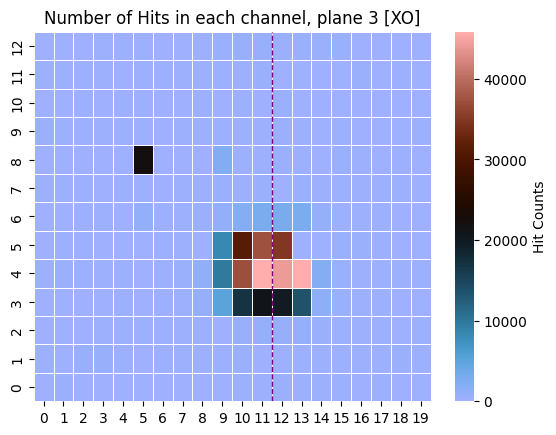

In [9]:
rf.hits_amount_colormap_single_plane(data_1491.hits,3)

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

1491 -tungsten only

In [10]:
data_1491_filtered = sf.filter_chi2_scope_data(data_1491,0.1, 10)

[14, 9, 12, 9, 13, 16, 9, 13, 13, 0, 0, ..., 11, 13, 14, 0, 0, 0, 0, 0, 0, 0, 0]


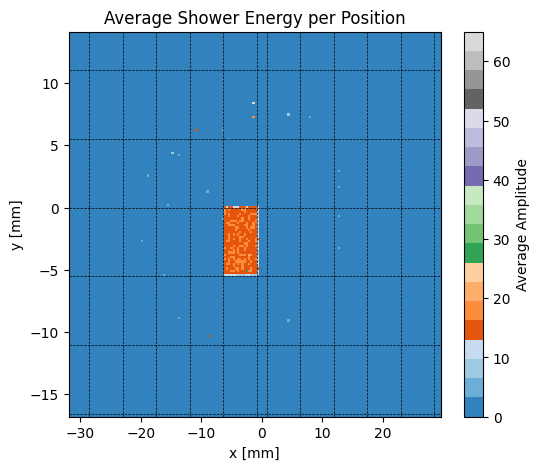

In [11]:
x_borders = "false"
y_borders = "false"

avg_energy_scope_colormap(data_1491_filtered, plane =2, x_center=0, y_center=-2, x_borders=x_borders, y_borders=y_borders, bins=170, cmap="tab20c", pad=91, channels_borders = "all")
# avg_energy_scope_colormap(data_1491_filtered, plane =2, x_center=0, y_center=-2, x_borders=x_borders, y_borders=y_borders, bins=170, cmap="tab20c", channels_borders = "all")

/Users/bentalmor/Desktop/LUXE/F-Cal-TB-Project/venv_2026/lib/python3.14/site-packages/awkward/_nplikes/array_module.py:289: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/var/folders/2p/r6vn4j655dl2xqksw7_604y40000gp/T/ipykernel_97238/616645234.py:42: RuntimeWarning: overflow encountered in exp
  return  A / (1.0 + np.exp(-(x - t) * r))


Sigmoid fit parameters:
A     = 14.337
t    = -0.604
r = -23.603


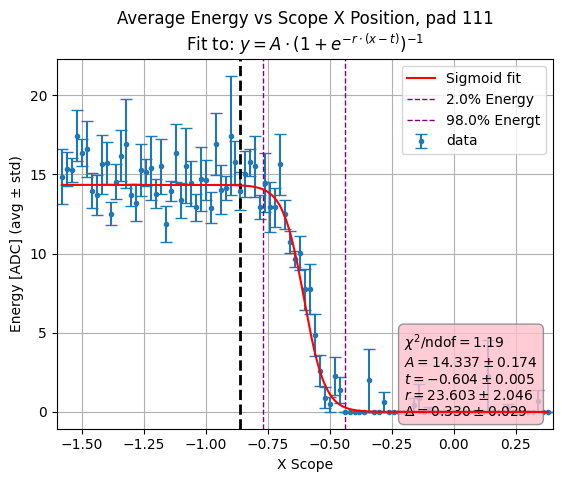

In [233]:
ymin = 0
t = -0.6
delta = 0.5
E_vs_X_scope_sigmoid(data_1491, 1.3, 2, ymin, ymin+5, t-2*delta, t+2*delta, bin_size=0.02, pad=111)

/var/folders/2p/r6vn4j655dl2xqksw7_604y40000gp/T/ipykernel_97238/2955861747.py:42: RuntimeWarning: overflow encountered in exp
  return  A / (1.0 + np.exp(-(x - t) * r))


5.902261506135873
5.600759618945852


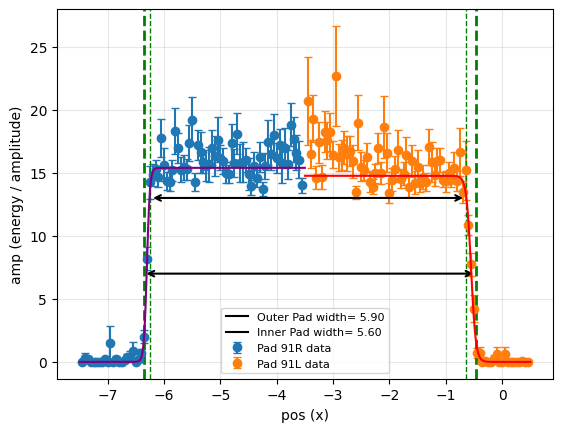

In [307]:
# visualize the pad width from left to right

ymin = -5
t = -0.5
delta = 1

popt_91R, pos_m_91R, amp_m_91R, err_m_91R,_,_ = E_vs_X_scope_sigmoid(data_1491, 1.3, 2, ymin, ymin+3, t-2*delta, t+2*delta, bin_size=0.05, pad=91, return_param=True)

# popt_91, pos_m_91, amp_m_91, err_m_91 = E_vs_X_scope_sigmoid(data_1491, 1.9, 2, ymin, ymin+5, t-3*delta, t+3*delta, bin_size=0.02, pad=91, return_param=True)

t = -6.3
popt_91L, pos_m_91L, amp_m_91L, err_m_91L,_,_ = E_vs_X_scope_sigmoid(data_1491, 1.3, 2, ymin, ymin+3, t-2*delta, t+2*delta, bin_size=0.05, pad=91, return_param=True)

# plot the energy deposition around the gap 

# sigmoid
def sigmoid_linear(x, A, t, r):
    return  A / (1.0 + np.exp(-(x - t) * r))

# create a smooth sigmoid for the fitted data
x_center = -3.5
x_lim = 4
x_fit_R = np.linspace(x_center, x_center+x_lim, 500)
x_fit_L = np.linspace(x_center-x_lim, x_center, 500)
y_fit_91R = sigmoid_linear(x_fit_R, *popt_91R)
y_fit_91L = sigmoid_linear(x_fit_L, *popt_91L)



'plot'
fig, ax = plt.subplots()

# mask the X values for the wanted range
mask_91R = (pos_m_91R > x_center-x_lim) & (pos_m_91R < x_center)
mask_91L = (pos_m_91L > x_center) & (pos_m_91L < x_center+x_lim)

# data points with errors
ax.errorbar(pos_m_91R[mask_91R], amp_m_91R[mask_91R], yerr=err_m_91R[mask_91R], fmt='o', capsize=3, label='Pad 91R data')
ax.errorbar(pos_m_91L[mask_91L], amp_m_91L[mask_91L], yerr=err_m_91L[mask_91L], fmt='o', capsize=3, label='Pad 91L data')

# plot sigmoids
ax.plot(x_fit_R, y_fit_91R, '-', color="red", zorder=7)
ax.plot(x_fit_L, y_fit_91L, '-', color="purple", zorder=7)

# rate and center of each sigmoid
r_91R = np.abs(popt_91R[2])
r_91L = np.abs(popt_91L[2])
t_91R = popt_91R[1]
t_91L = popt_91L[1]

# determine the width of the sigmoids
low_E = 0.1
high_E = 1-low_E
delta_91R = (2/r_91R)*np.log(high_E/low_E)
delta_91L = (2/r_91L)*np.log(high_E/low_E)
gap_width = np.abs((t_91L - delta_91L/2) - (t_91R + delta_91R/2))
outer_gap_width = np.abs((t_91L + delta_91L/2) - (t_91R - delta_91R/2))
print(gap_width)
print(outer_gap_width)

# vertical lines for the energy drops
'91R'
plt.axvline(x=t_91R - delta_91R/2, color='green', linestyle='--', linewidth=1)#, label=f"{high_E}A pad 91R")
plt.axvline(x=t_91R + delta_91R/2, color='green', linestyle='--', linewidth=2)#, label=f"{low_E}A pad 91R" )

'91L'
plt.axvline(x=t_91L - delta_91L/2, color='green', linestyle='--', linewidth=2)#, label=f"{low_E}A pad 91L")
plt.axvline(x=t_91L + delta_91L/2, color='green', linestyle='--', linewidth=1)#, label=f"{high_E}A pad 91L")

# arrow with gap width
arr = ax.annotate("", xy=(t_91R + delta_91R/2, 7), xytext=(t_91L - delta_91L/2, 7),
    arrowprops=dict(arrowstyle="<->", lw=1.5))
arr = ax.annotate("", xy=(t_91R - delta_91R/2, 13), xytext=(t_91L + delta_91L/2, 13),
    arrowprops=dict(arrowstyle="<->", lw=1.5))

# add notations of the pad width to the legend
ax.plot([], [], color='k', lw=1.5, label=f"Outer Pad width={gap_width: .2f}")
ax.plot([], [], color='k', lw=1.5, label=f"Inner Pad width={outer_gap_width: .2f}")

ax.set_xlabel("pos (x)")
ax.set_ylabel("amp (energy / amplitude)")
ax.legend(fontsize="8")
ax.grid(True, alpha=0.3)

plt.show()


<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

Automate pad edge

Sigmoid fit parameters:
A     = 14.478
t    = -6.302
r = 34.993


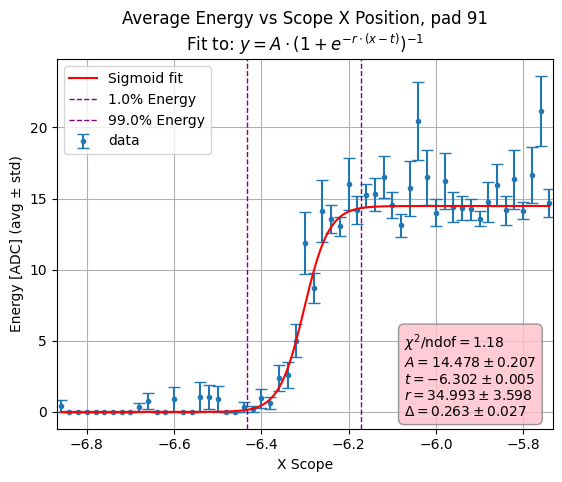

In [263]:
# pads edges analysis on X

# parameters
pad = 91
plane = 2
chi2 = 1.3
bin_size=0.02
low_E = 0.01  # amount of energy to determine the sigmoid borders
high_E = 1 - low_E
side = 0 # 0 for left edge, 1 for right

# get the pads edge
x_lines, y_lines = multiple_pad_edges_gridlines(pad)

# get the sigmoid data using pad edges
ymin = y_lines[0] + 1  # lower y bound
ymax = y_lines[1] - 1  # upper y bound
t_left1 = x_lines[side]    # initial center of the left edge sigmoid
t_right1 = x_lines[1]   # initial center of the right edge sigmoid
delta1 = 1              # initial width of data on x

popt, *_ = E_vs_X_scope_sigmoid(data_1491, chi2, plane, ymin, ymax,
                                                   t_left1-delta1, t_left1+delta1,
                                                   bin_size=bin_size,
                                                   pad=pad, low_E = low_E,
                                                   return_param=True)



# get the sigmoid data again using the fitted data
ymin = y_lines[0] + 1  # lower y bound
ymax = y_lines[1] - 1  # upper y bound
t = popt[1]            # center of sigmoid
r = popt[2]            # rate of sigmoid growth
delta = np.abs((2/r)*np.log(high_E/low_E))   # width of sigmoid
E_vs_X_scope_sigmoid(data_1491, chi2, plane, ymin, ymax,
                      t-2.1*delta, t+2.1*delta, bin_size=bin_size,
                        pad=pad, low_E = low_E, edges=False, ytext=0.26 + side*0.2)


# plot the data at the pad edge


In [17]:
# pads edges analysis on X

def pad_edge_sigmoid(data, plane, pad, chi2=2, low_E=0.02, bin_size=0.02, right=False, y_slice=3, initial_delta=1):
    'get the sigmoid parameters of the energy at the edge of a given pad'
    'return for the left edge unless right = True'

    # parameters
    high_E = 1 - low_E
    
    # y edges
    y_cut = (5 - y_slice)/2   # the pad part on y axis to discard from data
    x_lines, y_lines = multiple_pad_edges_gridlines(pad)
    ymin = y_lines[0] + y_cut  # lower y bound
    ymax = y_lines[1] - y_cut  # upper y bound

    # get the pads edge

    # get the initial sigmoid data using pad edges
    delta1 = initial_delta              # initial width of data on x
    pad_edge = 1 if right else 0  # determine left or right edge
    t1 = x_lines[pad_edge]   # initial center of the sigmoid

    popt, *_ = E_vs_X_scope_sigmoid(data, chi2, plane, ymin, ymax,
                                                    t1-delta1, t1+delta1,
                                                    bin_size=bin_size,
                                                    pad=pad, low_E = low_E,
                                                        return_param=True)


    # get the sigmoid data again using the fitted data
    t = popt[1]            # center of sigmoid
    r = popt[2]            # rate of sigmoid growth
    delta = np.abs((2/r)*np.log(high_E/low_E))   # width of sigmoid


    popt_final, _, _, _, delta_final, delta_err = E_vs_X_scope_sigmoid(data_1491, chi2, plane, ymin, ymax,
                        t-2*delta, t+2*delta, bin_size=bin_size,
                            pad=pad, low_E = low_E, return_param=True)
    
    return popt_final, delta_final, delta_err

/var/folders/2p/r6vn4j655dl2xqksw7_604y40000gp/T/ipykernel_97238/3015474825.py:42: RuntimeWarning: overflow encountered in exp
  return  A / (1.0 + np.exp(-(x - t) * r))


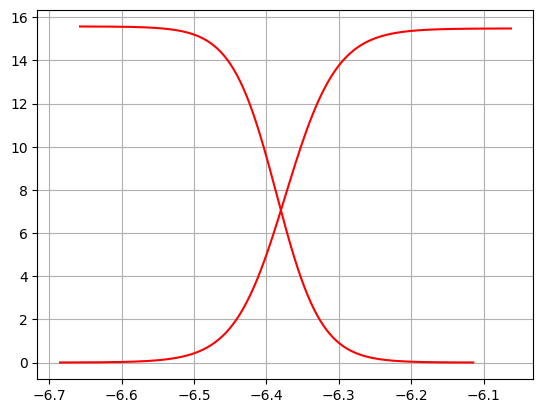

In [ ]:
# plot the sigmoid

# first pad
popt, delta, delta_err = pad_edge_sigmoid(data_1491, plane=0, pad=91, chi2=2, low_E=0.1, bin_size=0.02, right=False, y_slice=3)
t = popt[1]
xmin, xmax = t-2*delta, t+2*delta

# add the data to the crossing pads
# popt, pos, amp_avg, amp_std, delta, delta_errp = E_vs_X_scope_sigmoid(data_1491, chi2,plane, y_min=-10,
#                                                                        y_max=10, x_min=-20, x_max=20, bin_size = 0.4,
#                                                                          return_param=False, pad=True, low_E = 0.02, 
#                                                                          edges=True, ytext=0.26)

fig, ax = plt.subplots()

# make a smooth fitted function
x_fit = np.linspace(xmin, xmax, 500)
y_fit = sigmoid_linear(x_fit, *popt)
ax.plot(x_fit, y_fit, 'r-', label="Sigmoid fit", zorder=10)


# second pad
popt, delta, delta_err = pad_edge_sigmoid(data_1491, plane=0, pad=90, chi2=2, low_E=0.1, bin_size=0.02, right=True, y_slice=3)
t = popt[1]
xmin, xmax = t-2*delta, t+2*delta

# make a smooth fitted function
x_fit = np.linspace(xmin, xmax, 500)
y_fit = sigmoid_linear(x_fit, *popt)
ax.plot(x_fit, y_fit, 'r-', label="Sigmoid fit", zorder=10)

plt.grid()
plt.show()

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

X Edges for All Pads

In [90]:
# get the sigmoid width for multiple pads

pad_list_L = []
delta_list_L = []
delta_err_list_L = []

pad_list_R = []
delta_list_R = []
delta_err_list_R = []

failed = []

err_bound = 10000

for plane in range(2,11):

    # gather the data per plane
    pad_list_L1 = []
    delta_list_L1 = []
    delta_err_list_L1 = []
    pad_list_R1 = []
    delta_list_R1 = []
    delta_err_list_R1 = []

    for y in range(3,6):
        for x in range(10,14):
            pad = 20*y + x

            try:
                _, delta_L, delta_err_L = pad_edge_sigmoid(data_1491, plane=plane, pad=pad, chi2=1.3,
                                                        low_E=0.01, bin_size=0.02, right=False,
                                                        y_slice=3)
                
                
                if delta_err_L < err_bound:
                    pad_list_L1.append(pad)
                    delta_list_L1.append(delta_L)
                    delta_err_list_L1.append(delta_err_L)

            except Exception as e:
                failed.append((pad, type(e).__name__, str(e)))
        
    
                

            try:
                _, delta_R, delta_err_R = pad_edge_sigmoid(data_1491, plane=plane, pad=pad, chi2=1.3,
                                                        low_E=0.01, bin_size=0.02, right=True,
                                                        y_slice=3)
                
                if delta_err_R < err_bound:
                    pad_list_R1.append(pad)
                    delta_list_R1.append(delta_R)
                    delta_err_list_R1.append(delta_err_R)


            except Exception as e:
                failed.append((pad, type(e).__name__, str(e)))
                continue

    pad_list_L.append(pad_list_L1)
    delta_list_L.append(delta_list_L1)
    delta_err_list_L.append(delta_err_list_L1)
    
    pad_list_R.append(pad_list_R1)
    delta_list_R.append(delta_list_R1)
    delta_err_list_R.append(delta_err_list_R1)

/Users/bentalmor/Desktop/LUXE/F-Cal-TB-Project/venv_2026/lib/python3.14/site-packages/awkward/_nplikes/array_module.py:289: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/var/folders/2p/r6vn4j655dl2xqksw7_604y40000gp/T/ipykernel_97238/3015474825.py:42: RuntimeWarning: overflow encountered in exp
  return  A / (1.0 + np.exp(-(x - t) * r))
/var/folders/2p/r6vn4j655dl2xqksw7_604y40000gp/T/ipykernel_97238/3015474825.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(sigmoid_linear, pos_m, amp_m, p0=[A0, t0, r0], sigma=np.where(err_m > 0, err_m, 1.0),


In [97]:
# save the sigmoid widths
data = {
    "pad_L": pad_list_L,
    "delta_L": delta_list_L,
    "delta_err_L": delta_err_list_L,
    "pad_R": pad_list_R,
    "delta_R": delta_list_R,
    "delta_err_R": delta_err_list_R,
}

with open("pad_delta_data.json", "w") as f:
    json.dump(data, f, indent=2)


In [98]:
# load the sigmoid widths
with open("pad_delta_data.json", "r") as f:
    data = json.load(f)

pad_list_L1 = data["pad_L"]
delta_list_L1 = data["delta_L"]
delta_err_list_L1 = data["delta_err_L"]


pad_list_R1 = data["pad_R"]
delta_list_R1 = data["delta_R"]
delta_err_list_R1 = data["delta_err_R"]


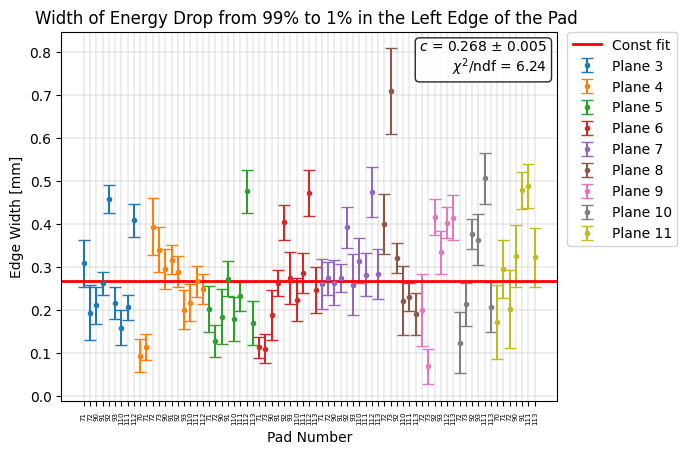

In [265]:
# plot the Left edge width for multyple pads

# filter out pads with high uncertainty
pads_L_ak, delta_L_ak, err_L_ak = ak.Array(pad_list_L1), ak.Array(delta_list_L1), ak.Array(delta_err_list_L1)
mask = err_L_ak < 0.1
pad_list_L, delta_list_L, delta_err_list_L = pads_L_ak[mask], delta_L_ak[mask], err_L_ak[mask]

offset = 0
for plane in range(len(pad_list_L)):
    xL_plane = offset + np.arange(len(pad_list_L[plane]))
    plt.errorbar(xL_plane, delta_list_L[plane], yerr=delta_err_list_L[plane], fmt='.', capsize=4, label=f"Plane {3+plane}")
    offset += len(pad_list_L[plane]) # to avoid the index of all planes from overlapping

pad_ak_L1 = ak.Array([pad_list_L])
pad_ak_L = ak.flatten(pad_ak_L1, axis = 2)[0]    # take all the pad numbers by order
xL = np.arange(len(pad_ak_L))

# ---- constant fit using weighted mean (weighted sum) ----

y_all = ak.flatten(delta_list_L)
err_all = ak.flatten(delta_err_list_L)

w = 1.0 / (err_all**2)
c_fit = np.sum(w * y_all) / np.sum(w)
c_err = np.sqrt(1.0 / np.sum(w))

chi2 = np.sum(((y_all - c_fit) / err_all)**2)
ndf = len(y_all) - 1
chi2_ndf = chi2 / ndf

plt.axhline(c_fit, linestyle="-", linewidth=2,
            color='red', label=fr"Const fit")

txt = (fr"$c$ = {c_fit:.3g} $\pm$ {c_err:.1g}" "\n"
       fr"$\chi^2$/ndf = {chi2_ndf:.2f}")
plt.gca().text(0.98, 0.98, txt,
               transform=plt.gca().transAxes,
               ha="right", va="top",
               bbox=dict(boxstyle="round", facecolor="white", alpha=0.85))



plt.xticks(xL, pad_ak_L, rotation=90, fontsize=5)  # ticks at x, labels = pad values
plt.xlabel("Pad Number")
plt.ylabel("Edge Width [mm]")
plt.title('Width of Energy Drop from 99% to 1% in the Left Edge of the Pad ')
plt.legend(loc = (1.02,0.42))
plt.grid(linewidth=0.3)
plt.show()

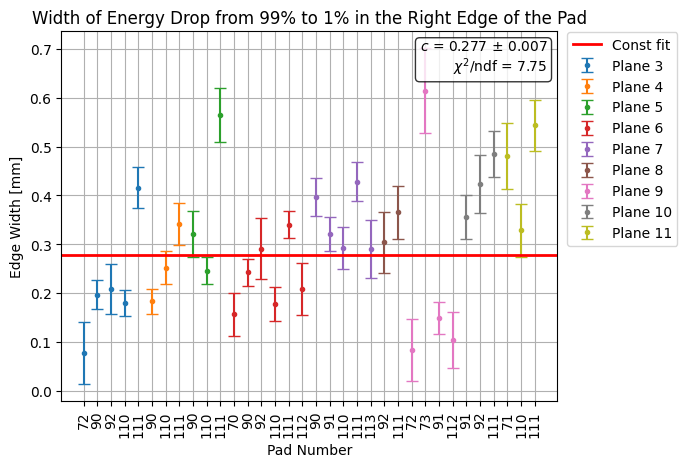

In [266]:
# plot the Right edge width for multyple pads

# filter out pads with high uncertainty
pads_R_ak, delta_R_ak, err_R_ak = ak.Array(pad_list_R1), ak.Array(delta_list_R1), ak.Array(delta_err_list_R1)
mask = err_R_ak < 0.1
pad_list_R, delta_list_R, delta_err_list_R = pads_R_ak[mask], delta_R_ak[mask], err_R_ak[mask]


# plot the data
offset = 0
for plane in range(len(pad_list_R)):
    xR_plane = offset + np.arange(len(pad_list_R[plane]))
    plt.errorbar(xR_plane, delta_list_R[plane], yerr=delta_err_list_R[plane], fmt='.', capsize=4, label=f"Plane {3+plane}")
    offset += len(pad_list_R[plane]) # to avoid the index of all planes from overlapping

pad_ak_R1 = ak.Array([pad_list_R])
pad_ak_R = ak.flatten(pad_ak_R1, axis = 2)[0]    # take all the pad numbers by order
xR = np.arange(len(pad_ak_R))

# Constant fit (weighted mean)

# collect all points from all planes into 1 array
y_all = ak.flatten(delta_list_R)
err_all = ak.flatten(delta_err_list_R)

# weighted mean (best constant)
w = 1.0 / (err_all**2)
c_fit = np.sum(w * y_all) / np.sum(w)
c_err = np.sqrt(1.0 / np.sum(w))

# chi2
chi2 = np.sum(((y_all - c_fit) / err_all)**2)
ndf = len(y_all) - 1
chi2_ndf = chi2 / ndf

# draw fit line across full x-range
plt.axhline(c_fit, linestyle="-", linewidth=2, color="red",
            label=fr"Const fit")

# textbox (top-right inside axes)
text = (fr"$c$ = {c_fit:.3g} $\pm$ {c_err:.1g}" "\n"
       fr"$\chi^2$/ndf = {chi2_ndf:.2f}")

plt.gca().text(0.98, 0.98, text,
               transform=plt.gca().transAxes,
               ha="right", va="top",
               bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))



plt.xticks(xR, pad_ak_R, rotation=90, fontsize=10)  # ticks at x, labels = pad values
plt.xlabel("Pad Number")
plt.ylabel("Edge Width [mm]")
plt.title('Width of Energy Drop from 99% to 1% in the Right Edge of the Pad')
plt.legend(loc = (1.02,0.42))
plt.grid()
plt.show()

<span style="font-family: Comic Sans MS; font-size:25px; color:orange">

Gap Width

/Users/bentalmor/Desktop/LUXE/F-Cal-TB-Project/venv_2026/lib/python3.14/site-packages/awkward/_nplikes/array_module.py:289: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


0.8437778953050253
1.6338300883241215


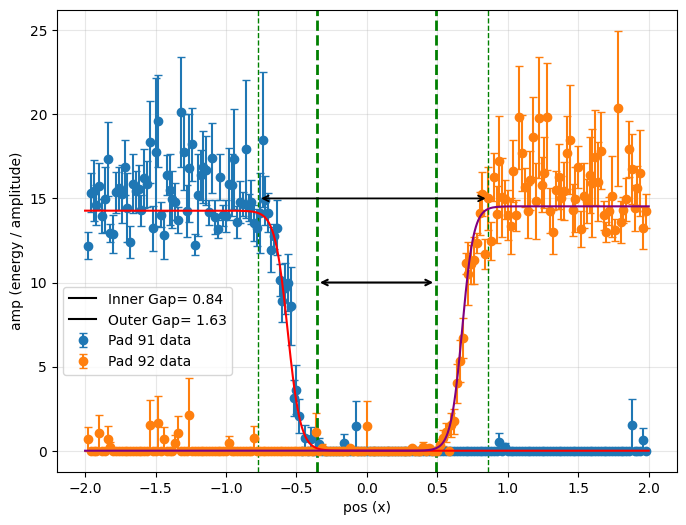

In [297]:
# visualize the gap between pad 91 and 92 (left and right of the gap)

ymin = -4
t = -0.5
delta = 1

popt_91, pos_m_91, amp_m_91, err_m_91, *_ = E_vs_X_scope_sigmoid(data_1491, 1.3, 2, ymin, ymin+3, t-2*delta, t+2*delta, bin_size=0.02, pad=91, low_E = 0.01, return_param=True)

# popt_91, pos_m_91, amp_m_91, err_m_91 = E_vs_X_scope_sigmoid(data_1491, 1.9, 2, ymin, ymin+5, t-3*delta, t+3*delta, bin_size=0.02, pad=91, return_param=True)

t = 0.7
popt_92, pos_m_92, amp_m_92, err_m_92, *_ = E_vs_X_scope_sigmoid(data_1491, 1.3, 2, ymin, ymin+3, t-2*delta, t+2*delta, bin_size=0.02, pad=92, low_E = 0.01, return_param=True)

# plot the energy deposition around the gap 

# sigmoid
def sigmoid_linear(x, A, t, r):
    return  A / (1.0 + np.exp(-(x - t) * r))

x_lim = 2
x_fit = np.linspace(-x_lim, x_lim, 500)
y_fit_91 = sigmoid_linear(x_fit, *popt_91)
y_fit_92 = sigmoid_linear(x_fit, *popt_92)


fig, ax = plt.subplots(figsize=(8, 6))
mask_91 = (pos_m_91 > -x_lim) & (pos_m_91 < x_lim)
mask_92 = (pos_m_92 > -x_lim) & (pos_m_92 < x_lim)

# data points with errors
ax.errorbar(pos_m_91[mask_91], amp_m_91[mask_91], yerr=err_m_91[mask_91], fmt='o', capsize=3, label='Pad 91 data')
ax.errorbar(pos_m_92[mask_92], amp_m_92[mask_92], yerr=err_m_92[mask_92], fmt='o', capsize=3, label='Pad 92 data')

# fitted sigmoids
ax.plot(x_fit, y_fit_91, '-', color="red", zorder=7)
ax.plot(x_fit, y_fit_92, '-', color="purple", zorder=7)

# width of each sigmoid
r_91 = np.abs(popt_91[2])
r_92 = np.abs(popt_92[2])
t_91 = popt_91[1]
t_92 = popt_92[1]

low_E = 0.01
high_E = 1-low_E
delta_91 = (2/r_91)*np.log(high_E/low_E)
delta_92 = (2/r_92)*np.log(high_E/low_E)
gap_width = (t_92 - delta_92/2) - (t_91 + delta_91/2)
outer_gap_width = (t_92 + delta_92/2) - (t_91 - delta_91/2)
print(gap_width)
print(outer_gap_width)

# vertical lines for the energy drops
'91'
plt.axvline(x=t_91 - delta_91/2, color='green', linestyle='--', linewidth=1)#, label=f"{high_E}A pad 91")
plt.axvline(x=t_91 + delta_91/2, color='green', linestyle='--', linewidth=2)#, label=f"{low_E}A pad 91" )

'92'
plt.axvline(x=t_92 - delta_92/2, color='green', linestyle='--', linewidth=2)#, label=f"{low_E}A pad 92")
plt.axvline(x=t_92 + delta_92/2, color='green', linestyle='--', linewidth=1)#, label=f"{high_E}A pad 92")

# arrow with gap width
# inner
arr = ax.annotate("", xy=(t_91 + delta_91/2, 10), xytext=(t_92 - delta_92/2, 10),
    arrowprops=dict(arrowstyle="<->", lw=1.5))

# outer
arr = ax.annotate("", xy=(t_91 - delta_91/2, 15), xytext=(t_92 + delta_92/2, 15),
    arrowprops=dict(arrowstyle="<->", lw=1.3, color='black'))

ax.plot([], [], color='k', lw=1.5, label=f"Inner Gap={gap_width: .2f}")
ax.plot([], [], color='k', lw=1.5, label=f"Outer Gap={outer_gap_width: .2f}")

ax.set_xlabel("pos (x)")
ax.set_ylabel("amp (energy / amplitude)")
ax.legend(loc=(0.01,0.21))
ax.grid(True, alpha=0.3)

plt.show()

In [210]:
# get the distance between inner and outer borders for pads around the gap
def distance_between_pads_gap(data, plane, left_pad, chi2=1.3, low_E=0.1, bin_size=0.02, y_slice=3,initial_delta=1):

    pads=[left_pad, left_pad + 1]
    sides = [True, False]       # Right, Left
    
    pad_data_list = []

    # get the sigmoids edges of both pads
    for pad, side in zip(pads, sides):
        
        # get the fit data for the pad 
        popt, delta, delta_err = pad_edge_sigmoid(data, plane, pad, chi2, low_E, bin_size, right=side, y_slice=y_slice, initial_delta=initial_delta)
        
        t = popt[1]
        left_edge = t - delta/2
        right_edge = t + delta/2
        
        # gather the data for the pad
        pad_data = []
        pad_data.append(left_edge)
        pad_data.append(right_edge)
        pad_data.append(delta_err)

        # save pads edges and err on external list
        pad_data_list.append(pad_data)

    
    left_pad_left_edge = pad_data_list[0][0]
    left_pad_right_edge = pad_data_list[0][1]
    left_pad_err = pad_data_list[0][2]
    
    right_pad_left_edge = pad_data_list[1][0]
    right_pad_right_edge = pad_data_list[1][1]
    right_pad_err = pad_data_list[1][2]

    inner_gap_width = right_pad_left_edge - left_pad_right_edge
    outer_gap_width = right_pad_right_edge - left_pad_left_edge
    gap_err = right_pad_err + left_pad_err


    return inner_gap_width, outer_gap_width, gap_err

In [120]:
distance_between_pads_gap(data_1491, plane=2, left_pad=91, chi2=1.3, low_E=0.02, bin_size=0.02, y_slice=3)

/Users/bentalmor/Desktop/LUXE/F-Cal-TB-Project/venv_2026/lib/python3.14/site-packages/awkward/_nplikes/array_module.py:289: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/var/folders/2p/r6vn4j655dl2xqksw7_604y40000gp/T/ipykernel_97238/3015474825.py:42: RuntimeWarning: overflow encountered in exp
  return  A / (1.0 + np.exp(-(x - t) * r))


(np.float64(0.8954474137018116),
 np.float64(1.619831495416785),
 np.float64(0.06593838423097358))

In [224]:
# get the Gap for multiple pads

inner_gap_list1 = []
outer_gap_list1 = []
gap_err_list1 = []
pads_list1 = []

failed = []


# get the width at the gap for specific pads
for plane in range(2,11):
    plane_pads_list = []
    plane_inner_gap_list = []
    plane_outer_gap_list = []
    plane_gap_err_list = []

    for y in range(3,7):
            pad = 20*y + 11

            try:
                inner_gap, outer_gap, gap_err = distance_between_pads_gap(data_1491, plane=plane,
                                                    left_pad=pad,
                                                    chi2=1.3, low_E=0.02,
                                                    bin_size=0.02, y_slice=3, initial_delta=1)
                
                plane_pads_list.append(pad)
                plane_inner_gap_list.append(inner_gap)
                plane_outer_gap_list.append(outer_gap)
                plane_gap_err_list.append(gap_err)

            except Exception as e:
                failed.append((pad, type(e).__name__, str(e)))

    pads_list1.append(plane_pads_list)
    inner_gap_list1.append(plane_inner_gap_list)
    outer_gap_list1.append(plane_outer_gap_list)
    gap_err_list1.append(plane_gap_err_list)

/Users/bentalmor/Desktop/LUXE/F-Cal-TB-Project/venv_2026/lib/python3.14/site-packages/awkward/_nplikes/array_module.py:289: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))
/var/folders/2p/r6vn4j655dl2xqksw7_604y40000gp/T/ipykernel_97238/3015474825.py:57: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(sigmoid_linear, pos_m, amp_m, p0=[A0, t0, r0], sigma=np.where(err_m > 0, err_m, 1.0),
/var/folders/2p/r6vn4j655dl2xqksw7_604y40000gp/T/ipykernel_97238/3015474825.py:42: RuntimeWarning: overflow encountered in exp
  return  A / (1.0 + np.exp(-(x - t) * r))


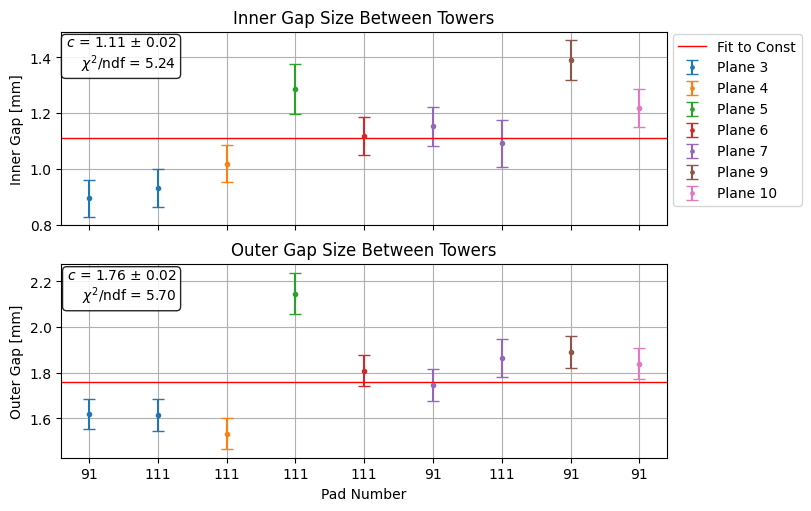

In [226]:

# --- filter out pads with high uncertainty ---
pads_ak  = ak.Array(pads_list1)
inner_ak = ak.Array(inner_gap_list1)
outer_ak = ak.Array(outer_gap_list1)
err_ak   = ak.Array(gap_err_list1)

mask = err_ak < 0.1
pads_list      = pads_ak[mask]
inner_gap_list = inner_ak[mask]
outer_gap_list = outer_ak[mask]
gap_err_list   = err_ak[mask]

# --- x positions per plane (same for both plots) ---
x_per_plane = []
offset = 0
for plane in range(len(pads_list)):
    n = len(pads_list[plane])
    x_per_plane.append(offset + np.arange(n))
    offset += n

pads_flat = ak.flatten(pads_list)
x = np.arange(len(pads_flat))

# --- make stacked subplots ---
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 5), constrained_layout=True)

# plot data
for plane in range(len(pads_list)):
    xp = x_per_plane[plane]
    if len(xp) > 0:   
        ax1.errorbar(xp, inner_gap_list[plane], yerr=gap_err_list[plane],
                    fmt='.', capsize=4, label=f"Plane {3+plane}")
        ax2.errorbar(xp, outer_gap_list[plane], yerr=gap_err_list[plane],
                    fmt='.', capsize=4, label=f"Plane {3+plane}")

# --- constant fits (weighted mean) + chi2 textboxes ---
def add_const_fit(ax, y_list, err_list, label_prefix="Const fit"):
    y_all = ak.flatten(y_list)
    err_all = ak.flatten(err_list)

    w = 1.0 / (err_all**2)
    c_fit = np.sum(w * y_all) / np.sum(w)
    c_err = np.sqrt(1.0 / np.sum(w))

    chi2 = np.sum(((y_all - c_fit) / err_all)**2)
    ndf = len(y_all) - 1
    chi2_ndf = chi2 / ndf

    ax.axhline(c_fit, linestyle="-", linewidth=1, color='red',
               label=fr"{label_prefix}")

    txt = (fr"$c$ = {c_fit:.3g} $\pm$ {c_err:.1g}" "\n"
           fr"$\chi^2$/ndf = {chi2_ndf:.2f}")
    ax.text(0.19, 0.98, txt, transform=ax.transAxes,
            ha="right", va="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.85))

add_const_fit(ax1, inner_gap_list, gap_err_list, label_prefix="Fit to Const")
add_const_fit(ax2, outer_gap_list, gap_err_list)

# labels / ticks
ax1.set_ylabel("Inner Gap [mm]")
ax1.set_title("Inner Gap Size Between Towers")
ax1.grid(True)
# ax1.legend(loc = (1.01,-0.3))
ax1.legend(fontsize=10, markerscale=0.8, loc=(1.01,0.1))

ax2.set_ylabel("Outer Gap [mm]")
ax2.set_title("Outer Gap Size Between Towers")
ax2.set_xlabel("Pad Number")
ax2.grid(True)

ax2.set_xticks(x)
ax2.set_xticklabels([str(p) for p in ak.to_list(pads_flat)], rotation=0)

plt.show()
